In [1]:
import sys 
sys.path.append('../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from NN import network, activation_functions, loss_functions
from NN import ANN


/root/.local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Simple Run Checks
To identify if there is no code broken

In [2]:
from importlib import reload
reload(network)
I = np.array([[0.05, 0.10]])
W = np.array([[0.15, 0.2], [0.25, 0.3]]).T
h1 = network.Layer(2, 2, 'sigmoid', weights=W, bias=0.35, label="H1")
netH, outH =  h1.feed_forward(I)
print(netH)
print(outH)

[[0.3775 0.3925]]
[[0.59326999 0.59688438]]


In [3]:
from importlib import reload
reload(network)
I = np.array([[0.59326999, 0.59688438]])
W = np.array([[0.4, 0.45], [0.50, 0.55]]).T
o1 = network.Layer(2, 2, 'sigmoid', weights=W, bias=0.6, label="H1")
netO, outO =  o1.feed_forward(I)
print(netO)
print(outO)

[[1.10590597 1.2249214 ]]
[[0.75136507 0.77292847]]


# Convergence Checkings
Based on the sample given by the class teacher

## Manual Calculations

In [4]:
from importlib import reload
reload(network)
model = network.NN(loss='smd')
X = np.array([[0.05, 0.10]])

Wh = np.array([[0.15, 0.2], [0.25, 0.3]]).T
h = network.Layer(2, 2, 'sigmoid', weights=Wh, bias=0.35, label="H1")

Wo = np.array([[0.4, 0.45], [0.50, 0.55]]).T
o = network.Layer(2, 2, 'sigmoid', weights=Wo, bias=0.6, label="H1")
model.add_layer(h)
model.add_layer(o)
model.show_weights()

Y, aY = model.feed_forward(X)
Y_, aY_ = ([1.10590597, 1.2249214 ], [0.75136507, 0.77292847])
print("Y\n",Y_)
print("\na(Y)\n",aY_)

assert((Y - Y_).sum() < np.finfo(np.float32).eps)
assert((aY - aY_).sum() < np.finfo(np.float32).eps)


Model Weights
-------------------------------
H1      (input=2, neurons=2, activation=sigmoid)
[[0.15 0.25]
 [0.2  0.3 ]]
H1      (input=2, neurons=2, activation=sigmoid)
[[0.4  0.5 ]
 [0.45 0.55]]
-------------------------------
Y
 [1.10590597, 1.2249214]

a(Y)
 [0.75136507, 0.77292847]


### Working on the back propagation

In [5]:
from importlib import reload
reload(network)
model.show_weights()
Y = np.array([0.01, 0.99])
Etotal = loss_functions.smd(aY, Y)
print(Etotal)
assert((Etotal - 0.2983711) < np.finfo(np.float32).eps)

Model Weights
-------------------------------
H1      (input=2, neurons=2, activation=sigmoid)
[[0.15 0.25]
 [0.2  0.3 ]]
H1      (input=2, neurons=2, activation=sigmoid)
[[0.4  0.5 ]
 [0.45 0.55]]
-------------------------------
0.2983711087600027


### Emulating the weights update for the layer O 

In [6]:
reload(loss_functions)
reload(activation_functions)
lr = 0.5
#Done - Partial
dEo_dw = loss_functions.smd_derivative_chain(outO, Y)
print(dEo_dw)

# Done
dOuto_Dneto = activation_functions.sigmoid_derivative_chain(outO)
print('dout',dOuto_Dneto)

# Done - Self.input
dNeto  = outH
print('dnet',dNeto) 
# Done
deltaO  = dEo_dw * dOuto_Dneto
print('delta', deltaO)

dWO = deltaO * outH
print('dw', dWO)
# Done
updateO = Wo - lr * dWO
print('update', updateO)

[[ 0.74136507 -0.21707153]]
dout [[0.1868156  0.17551005]]
dnet [[0.59326999 0.59688438]]
delta [[ 0.13849856 -0.03809824]]
dw [[ 0.08216704 -0.02274024]]
update [[0.35891648 0.51137012]
 [0.40891648 0.56137012]]


In [7]:
#
# Done - Partial
dEo_dOh = deltaO * Wo
dETotal_dOh = dEo_dOh.sum(axis=1)
print (dEo_dOh)
print('dETotal_dOh', dETotal_dOh)

# Done
dOuth_Dneth = activation_functions.sigmoid_derivative_chain(outH)
print('dOuth_Dneth', dOuth_Dneth)


# Done
deltaH = dETotal_dOh * dOuth_Dneth 
print('deltaH', deltaH)

# done
# self.input
dNeth_dw = X
dWh = deltaH * dNeth_dw
print('dWh', dWh)

# Done
updateH = Wh - lr * dWh
print('update', updateH)

[[ 0.05539942 -0.01904912]
 [ 0.06232435 -0.02095403]]
dETotal_dOh [0.03635031 0.04137032]
dOuth_Dneth [[0.24130071 0.24061342]]
deltaH [[0.00877135 0.00995425]]
dWh [[0.00043857 0.00099543]]
update [[0.14978072 0.24950229]
 [0.19978072 0.29950229]]


## Using the implemented Grad calculation for Layers

In [8]:
reload(loss_functions)
reload(activation_functions)
reload(network)
network.DEBUG = False

X = np.array([[0.05, 0.10], [0.05, 0.10]], np.float64)

# Wh = np.array([[0.15, 0.2], [0.25, 0.3]], np.float64).T
h = network.Layer(2, 10, 'sigmoid',  bias=0.35, label="H1")

# Wo = np.array([[0.4, 0.45], [0.50, 0.55]], np.float64).T
o = network.Layer(10, 2, 'sigmoid', bias=0.6, label="O")
Y = np.array([[0.01, 0.99], [0.01, 0.99]], np.float64)

for i in range(10000):
    netH, outH = h.feed_forward(X)
    netO, outO = o.feed_forward(outH)

    
    Etotal = loss_functions.smd(outO, Y)
    if (i % 1000) == 0:
        print(i, 'error', Etotal)
    
    dEo_dw = loss_functions.cross_entropy_derivative_chain(outO, Y)
    
    network.dprint(dEo_dw)
    network.dprint ("")
    network.dprint ("==========================================")
    network.dprint ("Back Propagate Layer O")
    network.dprint ("==========================================")
    o.backpropagate(dETotal_dOut=dEo_dw)
    network.dprint ("==========================================")
    network.dprint ("")

    network.dprint ("==========================================")
    network.dprint ("Back Propagate Layer H")
    network.dprint ("==========================================")
    h.backpropagate(output_layer=o)
    network.dprint ("==========================================")

print (outO)

0 error 0.96071132939975
1000 error 0.0001601216083159306
2000 error 0.00017951623928426981
3000 error 0.0001862230989718681
4000 error 0.0001896236984334605
5000 error 0.00019167917494260456
6000 error 0.0001930557158084457
7000 error 0.00019404194961147484
8000 error 0.00019478322200835535
9000 error 0.00019536068831676047
[[1.05748042e-04 9.99895786e-01]
 [1.05748042e-04 9.99895786e-01]]


# Using the Fit Methods with the full network calculation

## SMD as the Loss Function

In [9]:
from utils import dataset_helper
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)
network.DEBUG = False
eps = 0.00001

X = np.array([[0.05, 0.10]], np.float64)
Y = np.array([[0.01, 0.99]], np.float64)

# Wh = np.array([[0.15, 0.2], [0.25, 0.3]], np.float64).T
h = network.Layer(2, 3, 'sigmoid', bias=0.35, label="H1")

# Wo = np.array([[0.4, 0.45], [0.50, 0.55]], np.float64).T
o = network.Layer(3, 2, 'sigmoid', bias=0.6, label="Output")

model = network.NN(loss='smd')
model.add_layer(h)
model.add_layer(o)
model.show_weights()

model.fit(X, Y, max_iter=50000, 
          lr=0.5, epsilon=eps, b_sz=2, 
          print_interval=2000)

_, Y_ = model.feed_forward(X)

mae = np.absolute(Y - Y_).mean()
print(Y_, mae)
assert(mae < 0.01)

Model Weights
-------------------------------
H1      (input=2, neurons=3, activation=sigmoid)
[[0.93882413 0.19500006 0.16673673]
 [0.29650804 0.38296736 0.74113667]]
Output  (input=3, neurons=2, activation=sigmoid)
[[0.66385273 0.71361663]
 [0.82387165 0.9979182 ]
 [0.48388118 0.42768328]]
-------------------------------
Shuffled
It: 2000 Batch: 1 Epoch 1999 Error: 0.00553536 lr: 0.500000 
It: 4000 Batch: 1 Epoch 3999 Error: 0.00014716 lr: 0.500000 
It: 6000 Batch: 1 Epoch 5999 Error: 0.00006185 lr: 0.500000 
It: 8000 Batch: 1 Epoch 7999 Error: 0.00003328 lr: 0.500000 
It: 10000 Batch: 1 Epoch 9999 Error: 0.00002011 lr: 0.500000 
It: 12000 Batch: 1 Epoch 11999 Error: 0.00001300 lr: 0.500000 
It: 14000 Batch: 1 Epoch 13999 Error: 0.00000879 lr: 0.500000 
Finished 
 It: 14001 Batch: 1 Epoch 14000 Train Loss: 0.00000879 lr: 0.500000 
[[0.01270133 0.98730822]] 0.0026965590326849956


## Cross Entropy 

In [10]:
from utils import dataset_helper
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)
network.DEBUG = False
eps = 0.0001
X = np.array([[0.05, 0.10]], np.float64)
Y = np.array([[0.01, 0.99]], np.float64)

Wh = np.array([[0.15, 0.2], [0.25, 0.3]], np.float64).T
h = network.Layer(2, 2, 'sigmoid', weights=Wh, bias=0.35, label="H1")

Wo = np.array([[0.4, 0.45], [0.50, 0.55]], np.float64).T
o = network.Layer(2, 2, 'sigmoid', weights=Wo, bias=0.6, label="Output")

model = network.NN(loss='cross_entropy')
model.add_layer(h)
model.add_layer(o)
model.show_weights()

model.fit(X, Y, max_iter=10000,
          lr=0.1, epsilon=eps, 
          print_interval=2000)

_, Y_ = model.feed_forward(X)

mae = np.absolute(Y - Y_).mean()
print(Y_, mae)
assert(mae < 0.01)

Model Weights
-------------------------------
H1      (input=2, neurons=2, activation=sigmoid)
[[0.15 0.25]
 [0.2  0.3 ]]
Output  (input=2, neurons=2, activation=sigmoid)
[[0.4  0.5 ]
 [0.45 0.55]]
-------------------------------
Shuffled
It: 2000 Batch: 1 Epoch 1999 Error: 0.76574643 lr: 0.100000 
It: 4000 Batch: 1 Epoch 3999 Error: 0.66248688 lr: 0.100000 
It: 6000 Batch: 1 Epoch 5999 Error: 0.65524647 lr: 0.100000 
It: 8000 Batch: 1 Epoch 7999 Error: 0.65246400 lr: 0.100000 
It: 10000 Batch: 1 Epoch 9999 Error: 0.65099797 lr: 0.100000 
Finished 
 It: 10000 Batch: 1 Epoch 9999 Train Loss: 0.65099797 lr: 0.100000 
[[0.0038555  0.99623122]] 0.006187855935083348


In [11]:
from utils import dataset_helper
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)
network.DEBUG = False

eps = np.finfo(np.float32).eps

X = np.array([[0.05, 0.10], [0.05, 0.10], [0.10, 0.05]], np.float64)
Y = np.array([[0.0, 1], [0.0, 1], [1., 0.]], np.float64)

h1 = network.Layer(2, 10, 'sigmoid',  label="H1")
o = network.Layer(10, 2, 'sigmoid',  label="Output")

model = network.NN(loss='cross_entropy')
model.add_layer(h1)
model.add_layer(o)
model.show_weights()

model.fit(X, Y, max_iter=50000, 
          lr=0.9, epsilon=eps,
          print_interval=2000)

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1).flatten()
Y = Y.argmax(axis=-1)
mae = np.absolute(Y - Y_).mean()
print(mae)
print(Y, Y_)
assert(mae < 0.1)

Model Weights
-------------------------------
H1      (input=2, neurons=10, activation=sigmoid)
[[0.7278321  0.52009655 0.39918015 0.23696724 0.7736045  0.94884612
  0.42310302 0.57990131 0.84848208 0.94855152]
 [0.34801577 0.05642662 0.73882445 0.00230771 0.74707891 0.02962981
  0.72329036 0.57095065 0.97767136 0.42079226]]
Output  (input=10, neurons=2, activation=sigmoid)
[[0.95997424 0.86727522]
 [0.26026361 0.87896529]
 [0.395428   0.01318163]
 [0.39379508 0.36371827]
 [0.08316574 0.19400122]
 [0.14407298 0.5694082 ]
 [0.0966904  0.10178734]
 [0.82290464 0.91400647]
 [0.20374662 0.60130484]
 [0.43791923 0.91621748]]
-------------------------------
Shuffled
It: 2000 Batch: 2 Epoch 666 Error: 1.28613137 lr: 0.900000 
It: 4000 Batch: 1 Epoch 1333 Error: 1.28161702 lr: 0.900000 
It: 6000 Batch: 3 Epoch 1999 Error: 1.26640426 lr: 0.900000 
It: 8000 Batch: 2 Epoch 2666 Error: 1.03661381 lr: 0.900000 
It: 10000 Batch: 1 Epoch 3333 Error: 0.70017559 lr: 0.900000 
It: 12000 Batch: 3 Epoch 3

## Multi class Classification Test

In [12]:
nclasses = 5
nsamples = 60000
nfeatures = 60

X,  X_val, Y, Y_val = dataset_helper.get_toy_data_multiclass(nclasses, nsamples, nfeatures)
Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)

In [13]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X = scaler.fit_transform(X)
X_val = scaler.transform(X_val)

In [14]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)

eps = np.finfo(np.float32).eps


lr = .9
max_iter = 60 * X.shape[0]
print_interval = 10*1000

network.DEBUG = False

eps = np.finfo(np.float32).eps

h1 = network.Layer(nfeatures, 32, 'sigmoid', label="H1")
h2 = network.Layer(32, 64, 'sigmoid', label="H2")
h3 = network.Layer(64, 24, 'sigmoid', label="H3")
o = network.Layer(24, nclasses, 'sigmoid', label="Output")

model = network.NN(loss='smd')
model.add_layer(h1)
model.add_layer(h2)
model.add_layer(h3)
model.add_layer(o)
model.summary()


print("")
start = time.process_time()
model.fit(X, Y, max_iter=max_iter, 
          lr=lr, epsilon=eps, b_sz = 1,
          decay_iteractions= 2.5 * X.shape[0], decay_rate = 0.9,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1).flatten()
mae = np.absolute(Y.argmax(axis=-1) - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))
iteraction_log = network.get_iteration_log()

Model Summary
-------------------------------
H1      (input=60, neurons=32, activation=sigmoid)
H2      (input=32, neurons=64, activation=sigmoid)
H3      (input=64, neurons=24, activation=sigmoid)
Output  (input=24, neurons=5, activation=sigmoid)
-------------------------------

Shuffled
It: 10000 Batch: 10000 Epoch 0 Train Loss: 1.36657578 lr: 0.900000 Val Loss: 1.06702362
It: 20000 Batch: 20000 Epoch 0 Train Loss: 1.09489642 lr: 0.900000 Val Loss: 1.25005179
It: 30000 Batch: 30000 Epoch 0 Train Loss: 0.91366700 lr: 0.900000 Val Loss: 0.81649533
It: 40000 Batch: 40000 Epoch 0 Train Loss: 0.62271033 lr: 0.900000 Val Loss: 0.44435940
It: 50000 Batch: 2000 Epoch 1 Train Loss: 0.49507521 lr: 0.900000 Val Loss: 0.43634736
It: 60000 Batch: 12000 Epoch 1 Train Loss: 0.49657263 lr: 0.900000 Val Loss: 0.43590114
It: 70000 Batch: 22000 Epoch 1 Train Loss: 0.49351742 lr: 0.900000 Val Loss: 0.66531414
It: 80000 Batch: 32000 Epoch 1 Train Loss: 0.49131257 lr: 0.900000 Val Loss: 0.43663375
It: 90

It: 900000 Batch: 36000 Epoch 18 Train Loss: 0.44677339 lr: 0.430467 Val Loss: 0.42023392
It: 910000 Batch: 46000 Epoch 18 Train Loss: 0.44606588 lr: 0.430467 Val Loss: 0.42532126
It: 920000 Batch: 8000 Epoch 19 Train Loss: 0.44708259 lr: 0.430467 Val Loss: 0.41652225
It: 930000 Batch: 18000 Epoch 19 Train Loss: 0.44659447 lr: 0.430467 Val Loss: 0.60582586
It: 940000 Batch: 28000 Epoch 19 Train Loss: 0.44740048 lr: 0.430467 Val Loss: 0.42975697
It: 950000 Batch: 38000 Epoch 19 Train Loss: 0.44724726 lr: 0.430467 Val Loss: 0.41703145
It: 960000 Batch: 48000 Epoch 19 Train Loss: 0.44641090 lr: 0.430467 Val Loss: 0.42368046
It: 970000 Batch: 10000 Epoch 20 Train Loss: 0.44236296 lr: 0.387420 Val Loss: 0.45257934
It: 980000 Batch: 20000 Epoch 20 Train Loss: 0.44264561 lr: 0.387420 Val Loss: 0.48260209
It: 990000 Batch: 30000 Epoch 20 Train Loss: 0.44184217 lr: 0.387420 Val Loss: 0.43023297
It: 1000000 Batch: 40000 Epoch 20 Train Loss: 0.44263120 lr: 0.387420 Val Loss: 0.53543482
It: 101000

It: 1810000 Batch: 34000 Epoch 37 Train Loss: 0.42148348 lr: 0.185302 Val Loss: 0.43601040
It: 1820000 Batch: 44000 Epoch 37 Train Loss: 0.42099883 lr: 0.185302 Val Loss: 0.41533174
It: 1830000 Batch: 6000 Epoch 38 Train Loss: 0.42057018 lr: 0.185302 Val Loss: 0.41452096
It: 1840000 Batch: 16000 Epoch 38 Train Loss: 0.42048414 lr: 0.185302 Val Loss: 0.40772191
It: 1850000 Batch: 26000 Epoch 38 Train Loss: 0.42090071 lr: 0.185302 Val Loss: 0.41679459
It: 1860000 Batch: 36000 Epoch 38 Train Loss: 0.42097870 lr: 0.185302 Val Loss: 0.41129569
It: 1870000 Batch: 46000 Epoch 38 Train Loss: 0.42085604 lr: 0.185302 Val Loss: 0.40724518
It: 1880000 Batch: 8000 Epoch 39 Train Loss: 0.42089725 lr: 0.185302 Val Loss: 0.41358648
It: 1890000 Batch: 18000 Epoch 39 Train Loss: 0.42104421 lr: 0.185302 Val Loss: 0.41388406
It: 1900000 Batch: 28000 Epoch 39 Train Loss: 0.42172330 lr: 0.185302 Val Loss: 0.41224354
It: 1910000 Batch: 38000 Epoch 39 Train Loss: 0.42074846 lr: 0.185302 Val Loss: 0.41968439
I

It: 2720000 Batch: 32000 Epoch 56 Train Loss: 0.41019048 lr: 0.088629 Val Loss: 0.42289414
It: 2730000 Batch: 42000 Epoch 56 Train Loss: 0.41061096 lr: 0.088629 Val Loss: 0.40517369
It: 2740000 Batch: 4000 Epoch 57 Train Loss: 0.41018725 lr: 0.088629 Val Loss: 0.41160635
It: 2750000 Batch: 14000 Epoch 57 Train Loss: 0.40999942 lr: 0.088629 Val Loss: 0.42407892
It: 2760000 Batch: 24000 Epoch 57 Train Loss: 0.41068301 lr: 0.088629 Val Loss: 0.41633677
It: 2770000 Batch: 34000 Epoch 57 Train Loss: 0.40916820 lr: 0.079766 Val Loss: 0.40868129
It: 2780000 Batch: 44000 Epoch 57 Train Loss: 0.40911096 lr: 0.079766 Val Loss: 0.40284140
It: 2790000 Batch: 6000 Epoch 58 Train Loss: 0.40927515 lr: 0.079766 Val Loss: 0.40329655
It: 2800000 Batch: 16000 Epoch 58 Train Loss: 0.40932267 lr: 0.079766 Val Loss: 0.40154871
It: 2810000 Batch: 26000 Epoch 58 Train Loss: 0.40894806 lr: 0.079766 Val Loss: 0.40724473
It: 2820000 Batch: 36000 Epoch 58 Train Loss: 0.40915517 lr: 0.079766 Val Loss: 0.40369735
I

Validation Stats...
Accuracy: 0.199
Precision: nan
Recall: 0.200
F1 Score: 0.332407
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
Confusion matrix, without normalization
Normalized confusion matrix


../utils/custom_scores.py:29: RuntimeWarning: invalid value encountered in long_scalars
  precision += TP / (TP + FP)


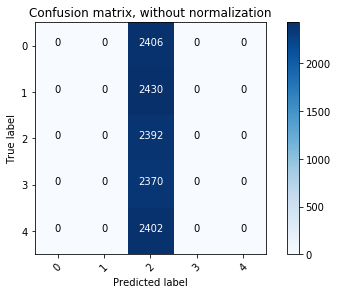

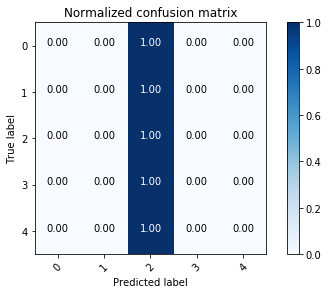

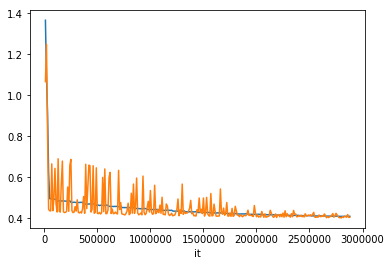

In [15]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
custom_scores.evalute_multiclass(Y_val.argmax(axis=-1), Y_val_.argmax(axis=-1))
iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()

In [16]:
from sklearn.preprocessing import RobustScaler
nclasses = 10
nsamples = 60000
nfeatures = 784
eps = np.finfo(np.float32).eps
X,  X_val, Y, Y_val = dataset_helper.get_toy_data_multiclass(nclasses, nsamples, nfeatures)

Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)

scaler = RobustScaler()
X = scaler.fit_transform(X)
X_val = scaler.transform(X_val)

In [ ]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)



eps = np.finfo(np.float128).eps
lr = .9
max_iter = 40 * X.shape[0]
print_interval = 10*1000

network.DEBUG = False

eps = np.finfo(np.float32).eps

# h1 = network.Layer(nfeatures, 128, 'sigmoid',label="H1")
# h2 = network.Layer(128, 256, 'sigmoid',label="H2")
# h3 = network.Layer(256, 32, 'sigmoid', label="H3")
# o = network.Layer(32, nclasses, 'sigmoid', label="Output")
h1 = network.Layer(nfeatures, 64, 'sigmoid', label="H1")
h2 = network.Layer(64, 64, 'sigmoid', label="H2")
h3 = network.Layer(64, 24, 'sigmoid', label="H3")
o = network.Layer(24, nclasses, 'sigmoid', label="Output")

model = network.NN(loss='smd')
model.add_layer(h1)
model.add_layer(h2)
model.add_layer(h3)
model.add_layer(o)
model.summary()


print("")
start = time.process_time()
model.fit(X, Y, max_iter=max_iter, 
          lr=lr, epsilon=eps, b_sz = 1,
          decay_iteractions=2. * X.shape[0], decay_rate = 0.9,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1).flatten()
Y = Y.argmax(axis=-1)
mae = np.absolute(Y - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))
iteraction_log = network.get_iteration_log()

Model Summary
-------------------------------
H1      (input=784, neurons=64, activation=sigmoid)
H2      (input=64, neurons=64, activation=sigmoid)
H3      (input=64, neurons=24, activation=sigmoid)
Output  (input=24, neurons=10, activation=sigmoid)
-------------------------------

Shuffled
It: 10000 Batch: 10000 Epoch 0 Train Loss: 3.41618438 lr: 0.900000 Val Loss: 2.48568869
It: 20000 Batch: 20000 Epoch 0 Train Loss: 1.91531834 lr: 0.900000 Val Loss: 1.67308536
It: 30000 Batch: 30000 Epoch 0 Train Loss: 1.51279390 lr: 0.900000 Val Loss: 1.34227662
It: 40000 Batch: 40000 Epoch 0 Train Loss: 1.18079804 lr: 0.900000 Val Loss: 0.86741301
It: 50000 Batch: 2000 Epoch 1 Train Loss: 0.88554753 lr: 0.900000 Val Loss: 0.86815124
It: 60000 Batch: 12000 Epoch 1 Train Loss: 0.88511472 lr: 0.900000 Val Loss: 0.86835478
It: 70000 Batch: 22000 Epoch 1 Train Loss: 0.88346240 lr: 0.900000 Val Loss: 0.86759042
It: 80000 Batch: 32000 Epoch 1 Train Loss: 0.56910750 lr: 0.900000 Val Loss: 0.51762576
It: 

It: 900000 Batch: 36000 Epoch 18 Train Loss: 0.46236769 lr: 0.348678 Val Loss: 0.48196442
It: 910000 Batch: 46000 Epoch 18 Train Loss: 0.46254630 lr: 0.348678 Val Loss: 0.45690293
It: 920000 Batch: 8000 Epoch 19 Train Loss: 0.46264195 lr: 0.348678 Val Loss: 0.47622252
It: 930000 Batch: 18000 Epoch 19 Train Loss: 0.46241354 lr: 0.348678 Val Loss: 0.46047159
It: 940000 Batch: 28000 Epoch 19 Train Loss: 0.46281448 lr: 0.348678 Val Loss: 0.45577379
It: 950000 Batch: 38000 Epoch 19 Train Loss: 0.46282657 lr: 0.348678 Val Loss: 0.45571953
It: 960000 Batch: 48000 Epoch 19 Train Loss: 0.46264430 lr: 0.348678 Val Loss: 0.45527840
It: 970000 Batch: 10000 Epoch 20 Train Loss: 0.46138038 lr: 0.313811 Val Loss: 0.45568523
It: 980000 Batch: 20000 Epoch 20 Train Loss: 0.46149705 lr: 0.313811 Val Loss: 0.45538420
It: 990000 Batch: 30000 Epoch 20 Train Loss: 0.46130968 lr: 0.313811 Val Loss: 0.45875608
It: 1000000 Batch: 40000 Epoch 20 Train Loss: 0.46151363 lr: 0.313811 Val Loss: 0.46055580
It: 101000

In [ ]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
custom_scores.evalute_multiclass(Y_val.argmax(axis=-1), Y_val_.argmax(axis=-1))
iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()